<a href="https://colab.research.google.com/github/DikshantPatel2210/Building-a-Custom-Transformer-based-Review-Rating-Prediction-with-Pretrained-DistilBERT/blob/main/Building_a_Custom_Transformer_based_Review_Rating_Prediction_with_Pretrained_DistilBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf

## Multi-Head Attention

This implementation of Multi-Head Attention uses the same Q, K, V matrices in each head. It also allows for inputs corresponding to padding to be masked out.

In [2]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads

        # Head dimension
        self.d_head = self.d_model // self.num_heads


        self.Wq = tf.keras.layers.Dense(self.d_model)
        self.Wk = tf.keras.layers.Dense(self.d_model)
        self.Wv = tf.keras.layers.Dense(self.d_model)


        self.dense = tf.keras.layers.Dense(self.d_model)


    def attention(self, query, key, value, mask=None):
        key_dim = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_scores = tf.matmul(query, key, transpose_b=True) / np.sqrt(key_dim)

        if mask is not None:
            scaled_scores = tf.where(mask==0, -np.inf, scaled_scores)

        softmax = tf.keras.layers.Softmax()
        weights = softmax(scaled_scores)
        return tf.matmul(weights, value), weights


    def split_heads(self, x):
        batch_size = x.shape[0]

        split_inputs = tf.reshape(x, (batch_size, -1, self.num_heads, self.d_head))
        return tf.transpose(split_inputs, perm=[0, 2, 1, 3])


    def merge_heads(self, x):
        batch_size = x.shape[0]

        merged_inputs = tf.transpose(x, perm=[0, 2, 1, 3])
        return tf.reshape(merged_inputs, (batch_size, -1, self.d_model))


    def call(self, q, k, v, mask):
        Q = self.Wq(q)
        K = self.Wk(k)
        V = self.Wv(v)

        Q = self.split_heads(Q)
        K = self.split_heads(K)
        V = self.split_heads(V)

        output, attention_weights = self.attention(Q, K, V, mask)
        output = self.merge_heads(output)

        return self.dense(output), attention_weights

In [3]:
class EncoderBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, hidden_dim, dropout_rate=0.1):
        super().__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffnn = self.feed_forward_neural_network(d_model, hidden_dim)


        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)


        self.layernorm1 = tf.keras.layers.LayerNormalization()
        self.layernorm2 = tf.keras.layers.LayerNormalization()

    def feed_forward_neural_network(self, d_model, hidden_dim):
        return tf.keras.Sequential([tf.keras.layers.Dense(hidden_dim, activation='relu'),
                    tf.keras.layers.Dense(d_model)])


    def call(self, x, mask):
        mha_output, attention_weights = self.mha(x, x, x, mask)
        mha_output = self.dropout1(mha_output)
        mha_output = self.layernorm1(x + mha_output)

        ffnn_output = self.ffnn(mha_output)
        ffnn_output = self.dropout2(ffnn_output)
        output = self.layernorm2(mha_output + ffnn_output)

        return output, attention_weights

# Encoder

In [4]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_blocks, d_model, num_heads, hidden_dim, src_vocab_size,
               max_seq_len, dropout_rate=0.1):
        super().__init__()
        self.d_model = d_model
        self.max_seq_len = max_seq_len

        # Embedding layers
        self.token_embed = tf.keras.layers.Embedding(src_vocab_size, self.d_model)
        self.positional_embed = tf.keras.layers.Embedding(max_seq_len, self.d_model)

        # Dropout
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

        # Encoder blocks
        self.blocks = [EncoderBlock(self.d_model, num_heads, hidden_dim, dropout_rate)
                        for _ in range(num_blocks)]

    # Forward pass
    def call(self, inpt, mask):
        token_embeds = self.token_embed(inpt)

        # Position indices for batch of input sequences
        num_pos = inpt.shape[0] * self.max_seq_len
        pos_idx = np.resize(np.arange(self.max_seq_len), num_pos)
        pos_idx = np.reshape(pos_idx, inpt.shape)
        pos_embeds = self.pos_embed(pos_idx)

        x = self.dropout(token_embeds + pos_embeds)

        # Pass input through decoder blocks
        for block in self.blocks:
            x, weights = block(x, mask)

        return x, weights

# Decoder block

In [5]:
class DecoderBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, hidden_dim, dropout_rate=0.1):
        super().__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffnn = self.feed_forward_neural_network(d_model, hidden_dim)

        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout3 = tf.keras.layers.Dropout(dropout_rate)

        self.layernorm1 = tf.keras.layers.LayerNormalization()
        self.layernorm2 = tf.keras.layers.LayerNormalization()
        self.layernorm3 = tf.keras.layers.LayerNormalization()

    # Feed forward neural network
    def feed_forward_neural_network(self, d_model, hidden_dim):
        return tf.keras.Sequential([tf.keras.layers.Dense(hidden_dim, activation='relu'),
                    tf.keras.layers.Dense(d_model)])

    # Forward pass
    def call(self, encoder_output, target, decoder_mask, memory_mask):
        mha_output1, attention_weights = self.mha1(target, target, target, decoder_mask)
        mha_output1 = self.dropout1(mha_output1)
        mha_output1 = self.layernorm1(mha_output1 + target)

        mha_output2, attention_weights = self.mha2(mha_output1, encoder_output,
                                                encoder_output, memory_mask)
        mha_output2 = self.dropout2(mha_output2)
        mha_output2 = self.layernorm2(mha_output2 + mha_output1)

        ffnn_output = self.ffnn(mha_output2)
        ffnn_output = self.dropout3(ffnn_output)
        output = self.layernorm3(ffnn_output + mha_output2)
        return output, attention_weights

# Decoder

In [6]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_blocks, d_model, num_heads, hidden_dim, target_vocab_size,
               max_seq_len, dropout_rate=0.1):
        super().__init__()

        self.d_model = d_model
        self.max_seq_len = max_seq_len

        self.token_embed = tf.keras.layers.Embedding(target_vocab_size, self.d_model)
        self.pos_embed = tf.keras.layers.Embedding(max_seq_len, self.d_model)

        self.dropout = tf.keras.layers.Dropout(dropout_rate)

        self.blocks = [DecoderBlock(d_model, num_heads, hidden_dim, dropout_rate) for _ in range(num_blocks)]

    def call(self, encoder_output, target, decoder_mask, memory_mask):
        token_embeds = self.token_embed(target)

        # Position indices for batch of sequences
        num_pos = target.shape[0] * self.max_seq_len
        pos_idx = np.resize(np.arange(self.max_seq_len), num_pos)
        pos_idx = np.reshape(pos_idx, target.shape)
        pos_embeds = self.pos_embed(pos_idx)

        x = self.dropout(token_embeds + pos_embeds)

        for block in self.blocks:
            x, weights = block(encoder_output, x, decoder_mask, memory_mask)

        return x, weights

# Transfomer

In [7]:
class Transformer(tf.keras.Model):
    def __init__(self, num_blocks, d_model, num_heads, hidden_dim, source_vocab_size,
               target_vocab_size, max_input_len, max_target_len, dropout_rate=0.1):
        super().__init__()

        self.encoder = Encoder(num_blocks, d_model, num_heads, hidden_dim, source_vocab_size,
                               max_input_len, dropout_rate)

        self.decoder = Decoder(num_blocks, d_model, num_heads, hidden_dim, target_vocab_size,
                               max_target_len, dropout_rate)


        self.output_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, input_seqs, target_input_seqs, encoder_mask, decoder_mask, memory_mask):
        encoder_output, encoder_attention_weights = self.encoder(input_seqs, encoder_mask)

        decoder_output, decoder_attention_weights = self.decoder(encoder_output, target_input_seqs,
                                                            decoder_mask, memory_mask)

        return self.output_layer(decoder_output), encoder_attention_weights, decoder_attention_weights

# Fine Tuning

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.6)
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import os
os.environ["WANDB_DISABLED"] = "true"

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments


In [9]:
!pip install datasets

from datasets import load_dataset


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [10]:
import datasets

# Load data

In [12]:
# Load data
train = pd.read_csv("/content/train12.csv")
test = pd.read_csv("/content/test.csv")
sub = pd.read_csv("/content/sample_submission.csv")

print(train.shape)
train.head(5)


(60000, 3)


,Id,Review,Rating
0,0,Very good value and a great tv very happy and ...,5
1,1,After 6 month still can't access my account,3
2,2,I couldn't make an official review on a produc...,1
3,3,"Fantastic! Extremely easy to use website, fant...",5
4,4,So far annoyed as hell with this bt monthly pa...,1


<ipython-input-13-1e9fa2585a54>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train, x="Rating",palette="tab10" )


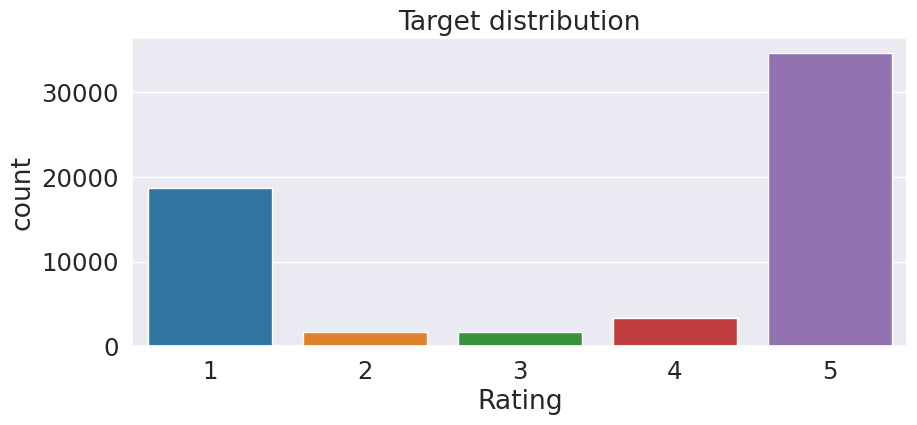

In [13]:
plt.figure(figsize=(10,4))
sns.countplot(data=train, x="Rating",palette="tab10" )
plt.title("Target distribution")
plt.show()

# Pre-process data

In [14]:

train["Rating"] = train["Rating"] - 1


X_train, X_valid, _, _ = train_test_split(train, train["Rating"], test_size=0.2, shuffle=True, random_state=0)


X_train[["Review","Rating"]].rename(columns={"Review":"text", "Rating":"label"}).to_csv("new_train.csv", index=False)
X_valid[["Review","Rating"]].rename(columns={"Review":"text", "Rating":"label"}).to_csv("new_valid.csv", index=False)
test[["Review"]].rename(columns={"Review":"text"}).to_csv("new_test.csv", index=False)


# Datasets

In [15]:

train_ds = load_dataset("csv", data_files={"train": "new_train.csv"})
valid_ds = load_dataset("csv", data_files={"valid": "new_valid.csv"})
test_ds = load_dataset("csv", data_files={"test": "new_test.csv"})

train_ds = train_ds.cast(datasets.Features({"text": datasets.Value("string"), "label": datasets.ClassLabel(num_classes=5)}))
valid_ds = valid_ds.cast(datasets.Features({"text": datasets.Value("string"), "label": datasets.ClassLabel(num_classes=5)}))

print(train_ds)
print(valid_ds)
print(test_ds)

Generating train split: 0 examples [00:00, ? examples/s]

Generating valid split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Casting the dataset:   0%|          | 0/48000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/12000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 48000
    })
})
DatasetDict({
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 12000
    })
})
DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 40000
    })
})


# Tokenizer

In [16]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

# Tokenize batch

In [17]:

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

# Apply tokenization
batch_size = 32
train_encoded = train_ds.map(tokenize, batched=True, batch_size=batch_size)
valid_encoded = valid_ds.map(tokenize, batched=True, batch_size=batch_size)
test_encoded = test_ds.map(tokenize, batched=True, batch_size=batch_size)

Map:   0%|          | 0/48000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

# Model

In [18]:
# Connect to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Download model
num_labels = 5
model = (AutoModelForSequenceClassification
         .from_pretrained(model_name, num_labels=num_labels)
         .to(device))

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Metrics

These get computed at the end of every epoch on the validation dataset. We've added in the competition metric, which is Mean Absolute Error (MAE).

In [19]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    mae = mean_absolute_error(labels, preds)
    return {"mae": mae, "accuracy": acc, "f1": f1}

# Train model

In [20]:
logging_steps = len(train_encoded["train"]) // batch_size
model_name_out = f"{model_name}-finetuned-emotion"


training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=3,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error")

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [21]:

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=train_encoded["train"],
                  eval_dataset=valid_encoded["valid"],
                  tokenizer=tokenizer)

# Train model
trainer.train()

<ipython-input-21-db31b419fe28>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Mae,Accuracy,F1
1,0.389900,0.342672,0.161333,0.891167,0.868326
2,0.294500,0.331442,0.153917,0.892333,0.877708
3,0.241500,0.351706,0.155333,0.886833,0.878852


TrainOutput(global_step=4500, training_loss=0.3085870429144965, metrics={'train_runtime': 6858.6777, 'train_samples_per_second': 20.995, 'train_steps_per_second': 0.656, 'total_flos': 1.907616863598816e+16, 'train_loss': 0.3085870429144965, 'epoch': 3.0})

# Evaluate

In [22]:

valid_preds = trainer.predict(valid_encoded["valid"])
valid_preds = np.argmax(valid_preds.predictions, axis=1)


y_valid = np.array(valid_ds["valid"]["label"])
labels = train_ds["train"].features["label"].names

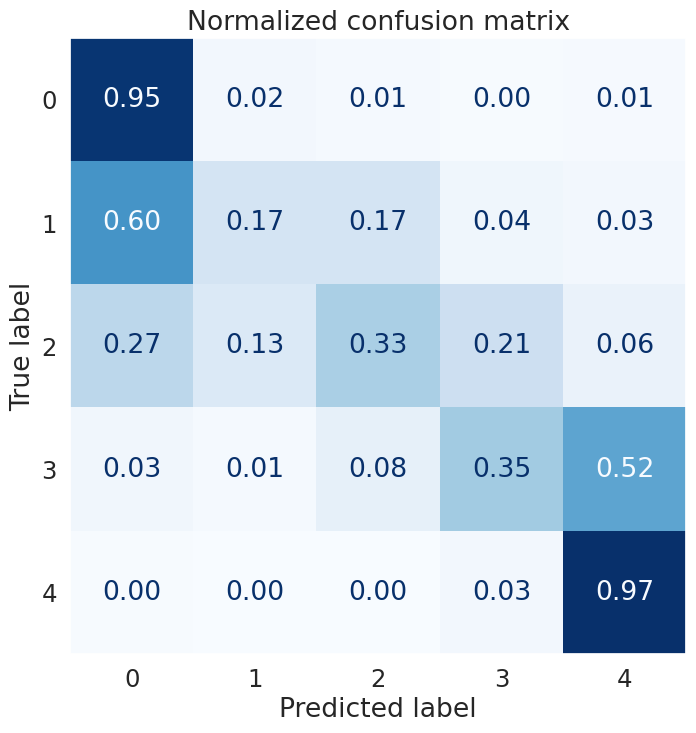

In [23]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    ax.grid(False)
    plt.show()

plot_confusion_matrix(valid_preds, y_valid, labels)

# Test set predictions

In [24]:
# Test set predictions
preds = trainer.predict(test_encoded["test"])
test_preds = np.argmax(preds.predictions, axis=1)

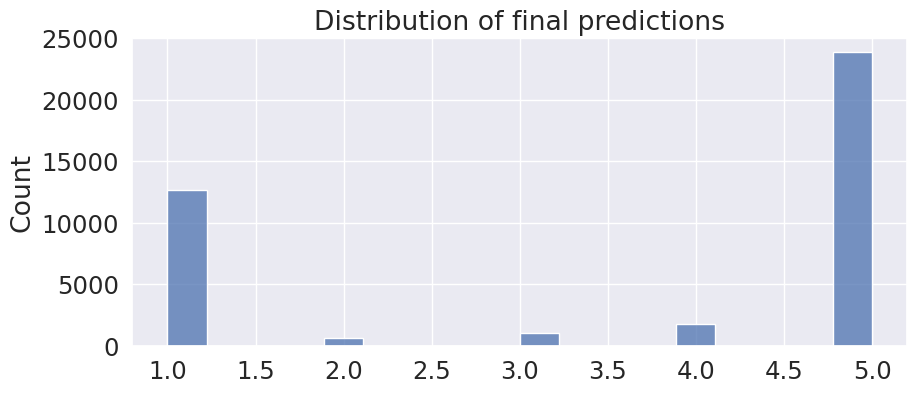

In [25]:
# Distribution of predictions
plt.figure(figsize=(10,4))
sns.histplot(test_preds+1)
plt.title("Distribution of final predictions")
plt.show()